# Deconvolution Tutorial

## Introduction

There are several problems with the standard initialization performed in the [Quickstart Guide](../0-quickstart.ipynb):

1. The models exist in a frame with a narrow model PSF while the the observed scene will have a much wider PSF. So the initial models will be spread out over a larger region, which causes more blending and an increased number of iterations for convergence.

1. The initial morphologies for `ExtendedSource`s and `MultibandSource`s are determined using a combined "detection coadd," which weights each observed image with the SED at the center of each source. Due to different seeing in each band, this results in artificial color gradients in the detection coadd that produce a less accurate initial model.

One way to solve these problems is to deconvolve the observations into the model frame where the PSF is the same in each band, resulting in more accurate initial morphologies and colors. This is not a trivial task, as deconvolution of a noisy image is an ill-defined operation and numerical divergences dominate the matching kernel when matching a wider PSF to a narrower PSF in Fourier space.

To avoid the numerical instability of deconvolution kernels created in k-space we instead use scarlet itself to model the kernel and deconvolve the image. There is a computational cost to this procedure and creating the deconvolution kernel for use with a single blend is not advisable, as the cost to generate it is greater than the time saved. However, there are some situations where the following procedure is quite useful, including deblending a large number of blends from survey data where the PSF is well-behaved. For example, we have experimented with HSC data and found that if we calculate the deconvolution kernel at the center of a 4k$\times$4k patch, we can use the result to deconvolve _all_ of the blends from the same coadd. This is possible because the deconvolution doesn't have to be exact, we just require it to be better for _initialization_ than the observed images.

In [1]:
# Import Packages and setup
from functools import partial

import numpy as np
import scarlet
import scarlet.display as display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a good colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno', interpolation='none', origin='lower')

## Load and Display Data

We load the same example data set used in the quickstart guide.

In [2]:
# Load the sample images
data = np.load("../../data/hsc_cosmos_35.npz")
images = data["images"]
filters = data["filters"]
catalog = data["catalog"]
weights = 1/data["variance"]
# Note that unlike in the quickstart guide,
# we set psfs the data["psfs"] image
# not a scarlet.PSF object.
psfs = data["psfs"]

## Generate the PSF models

Unlike the [Quickstart Guide](../0-quickstart.ipynb), we cannot use the pixel integrated model PSF because the [error function](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.erf.html) in scipy used to integrate the gaussian goes to zero too quickly to match an observed PSF. So instead we use a gaussian with a similar $\sigma=1/\sqrt{2}$ for our model. We then make this the _observed_ PSF, since this is the seeing that we want to deconvolve our observed images into.

In [3]:
py, px = np.array(psfs.shape[1:])//2
model_psf = scarlet.psf.gaussian(py, px, 1/np.sqrt(2), bbox=scarlet.Box(psfs.shape), integrate=False)[0]
model_psf = model_psf/model_psf.sum()
model_psf = np.array([model_psf]*psfs.shape[0])
model_frame = scarlet.Frame(psfs.shape,channels=filters)

psf_observation = scarlet.PsfObservation(model_psf, channels=filters).match(psfs)

No PSF specified. Possible, but dangerous!


No PSF specified. Possible, but dangerous!


## Matching the PSFs

### Algorithm

To understand how the matching algorithm works it is useful to understand how convolutions are performed in scarlet. We can define the observed PSF $P$ by convolving the model PSF $M$ with the difference kernel $D$, giving us

$P = M * D$,

where `*` is the convolution operator. The difference kernel is calculated in k-space using the ratio $\tilde{P}/\tilde{D}$, which is well defined as long as $P$ is wider than $M$ in real space. Then the `Observation.render` method is used to convolve the model with $D$ to match it with the observed seeing.

For deconvolution we require the opposite, namely

$M = P * D$

As mentioned in the [Introduction](#Introduction) this is numerically unstable because in k-space $\tilde{D}/\tilde{P}$ diverges in the wings as $\tilde{P}$ is narrower than $\tilde{D}$. Modeling the deconvolution kernel with scarlet is possible because of the commutivity of the convolution operation, where

$M = D * P$.

In this case we can define $M$ as the observation we seek to match, make $D$ the model we want to fit, and then convolve the model ($D$) with $P$ in each iteration to match the "data." In this way we can fit the deconvolution kernel needed to deconvolve from the observation seeing to the model frame.

## An implementation

Choosing the correct parameters for PSF matching is a bit of a black art in itself, another reason why deconvolution should only be done when deblending large datasets and the payoff is greater than the cost. For 41$\times$41 pixel HSC PSFs we've found the following initialization script to work well, however the configuration for your observations may differ substantially.

We introduce the `PSFDiffKernel` class, which acts like a scarlet `Component` used to model the scene, however in this case there is a "source" for each band since we want out deconvolution kernels to be mono-chromatic.

CPU times: user 2.23 s, sys: 260 ms, total: 2.49 s
Wall time: 2.49 s


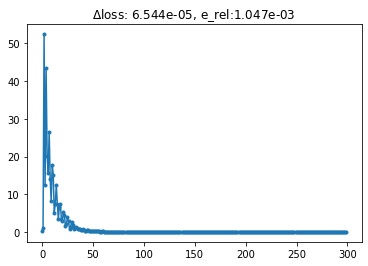

g: chi^2=0.059, max(abs)=0.108


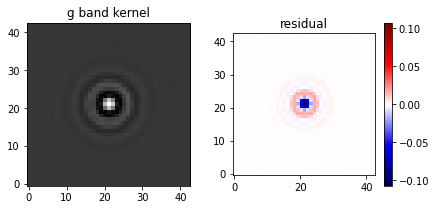

r: chi^2=0.064, max(abs)=0.161


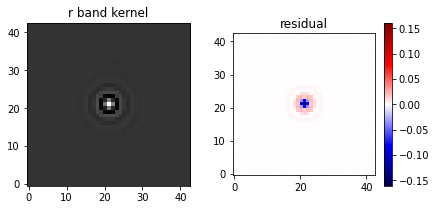

i: chi^2=0.067, max(abs)=0.146


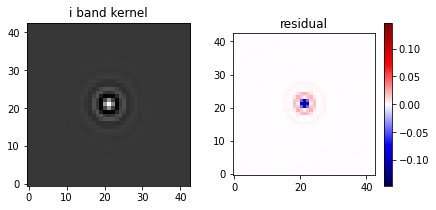

z: chi^2=0.068, max(abs)=0.162


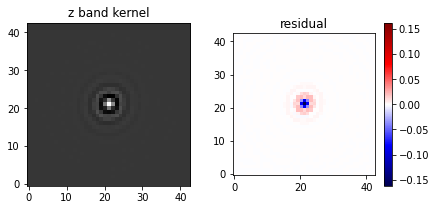

y: chi^2=0.069, max(abs)=0.136


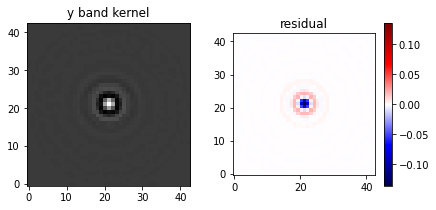

In [4]:
# Parameters used to initial and configure the fit.
max_iter = 300
e_rel = 1e-5
morph_step = 1e-2
# We should be able to improve our initial guess if we model the
# width of the observed PSF and calculate an analytic solution
# for the deconvolution kernel, however for now just using the
# observed PSF works well.
init_guess = psfs.copy()


psf_kernels = [
    scarlet.PSFDiffKernel(model_frame, init_guess, band, morph_step)
    for band in range(len(filters))
]

psf_blend = scarlet.Blend(psf_kernels, psf_observation)
%time psf_blend.fit(max_iter, e_rel=e_rel)
plt.plot(psf_blend.loss, ".-")
plt.title("$\Delta$loss: {:.3e}, e_rel:{:.3e}".format(psf_blend.loss[-2]-psf_blend.loss[-1], (psf_blend.loss[-2]-psf_blend.loss[-1])/np.abs(psf_blend.loss[-1])))
plt.show()

for band, src in enumerate(psf_blend.sources):
        residual = psfs[band]-psf_observation.render(psf_blend.get_model())[band]
        print("{}: chi^2={:.3f}, max(abs)={:.3f}".format(filters[band], np.sum(residual**2), np.max(np.abs(residual))))
        fig, ax = plt.subplots(1, 2, figsize=(7, 3))
        ax[0].imshow(src.get_model()[band], cmap="Greys_r")
        ax[0].set_title("{} band kernel".format(filters[band]))
        vmax = np.max(np.abs(residual))
        im = ax[1].imshow(residual, vmin=-vmax, vmax=vmax, cmap="seismic")
        ax[1].set_title("residual")
        plt.colorbar(im, ax=ax[1])
        plt.show()

The residual is created by convolving the observed PSF with the deconvolution kernel and comparing it to the model PSF. We see that the kernel isn't perfect and that it tends to overshoot the center of the model PSF, but the result is good enough to improve our initialization. One thing that we've noticed is that if we set our relative error too low then the ringing in the wings of bright objects is too large while running for too long makes the images crisper at the cost of amplifying the noise to the point where it isn't useful for faint (and even moderately faint) sources.

We now create the frame for our model, using an analytic PSF, and an observation for the deconvolved image. This is a `DeconvolvedObservation` class, which sets the deconvolution kernel.

In [5]:
# This is the frame for our model
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=1/np.sqrt(2)), shape=(None, 11, 11))
model_frame = scarlet.Frame(
            images.shape,
            psfs=model_psf,
            channels=filters)

# This object will perform the deconvolution
deconvolved = scarlet.DeconvolvedObservation(
            images,
            psfs=model_psf,
            weights=weights,
            channels=filters).match(model_frame, psf_blend.get_model())

# These are the observations that we want to model
observation = scarlet.Observation(
            images,
            psfs=scarlet.PSF(psfs),
            weights=weights,
            channels=filters).match(model_frame)

Let's take a look at the result:

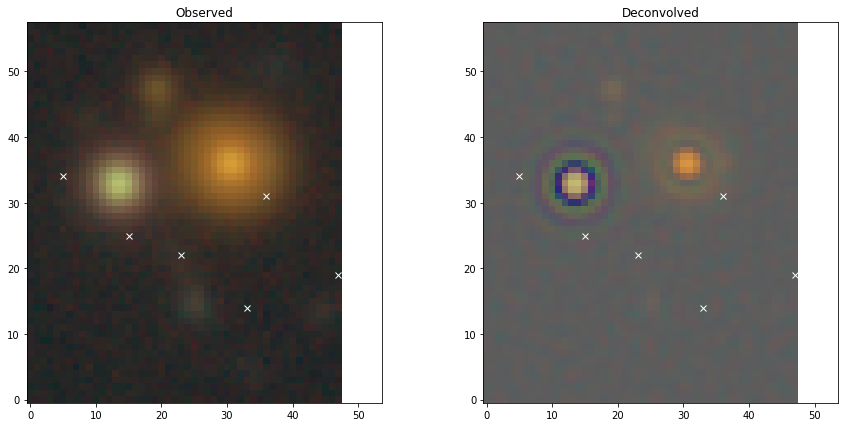

In [6]:
model = deconvolved.images

fig, ax = plt.subplots(1, 2, figsize=(15,7))

norm = display.AsinhMapping(minimum=np.min(images), stretch=np.max(images)*0.055, Q=10)
rgb = display.img_to_rgb(images, norm=norm)
ax[0].imshow(rgb)
ax[0].set_title("Observed")
for center in catalog:
    ax[0].plot(center[1], center[0], "wx")

norm = display.AsinhMapping(minimum=np.min(model), stretch=np.max(model)*0.055, Q=10)
rgb = display.img_to_rgb(model, norm=norm)
ax[1].imshow(rgb)
ax[1].set_title("Deconvolved")
for center in catalog:
    ax[1].plot(center[1], center[0], "wx")

plt.show()

In the case the result isn't great due to the bright star at the center. We could try to fit the model a bit better to supress the ringing but it turns out this is usually unnecessary and not worth the extra computation time.

To see how this is useful lets take a look at the detection coadds for the brightest 3 sources with and without deconvolution. These detection coadds are built internally for all extended and multiband sources, but it's a useful exercise to build them separately just to take a look at them. The red x's in the plots below mark the location of the source whose SED was used to make that particular detection coadd:

/home/travis/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == '':
/home/travis/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log10


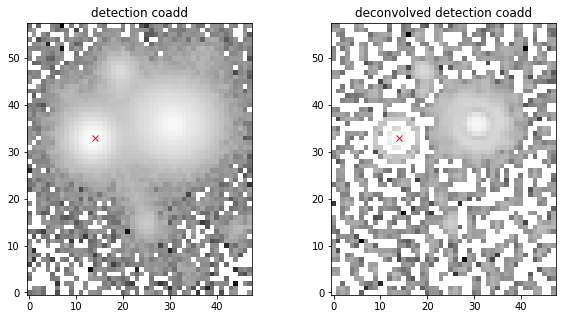

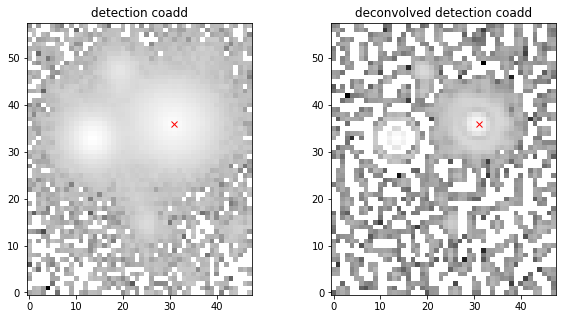

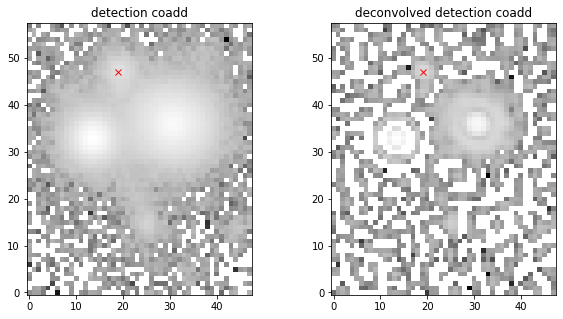

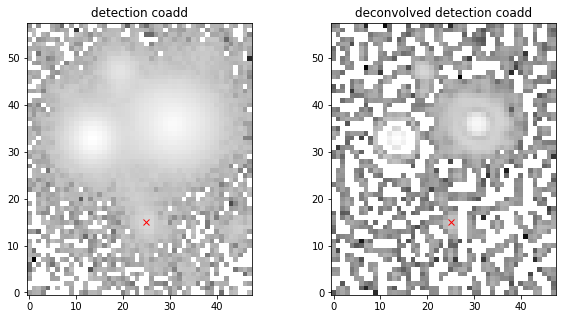

In [7]:
# We just define a rough estimate of the background RMS needed
# for `build_detection_coadd`.
bg_rms=np.zeros((len(images),))
bg_rms[:] = 1e-3
for center in catalog[:4]:
    center = (center[1], center[0])
    figure, ax = plt.subplots(1, 2, figsize=(10, 5))
    # Build the deconvolved coadd
    sed = scarlet.source.get_psf_sed(center, deconvolved, model_frame)
    detect, bg_cutoff = scarlet.source.build_detection_coadd(sed, bg_rms, deconvolved)
    # display
    ax[1].imshow(np.log10(detect), cmap="Greys_r")
    ax[1].plot(center[1], center[0], "rx")
    ax[1].set_title("deconvolved detection coadd")
    # Build the coadd without deconvolution
    sed = scarlet.source.get_psf_sed(center, observation, model_frame)
    detect, bg_cutoff = scarlet.source.build_detection_coadd(sed, bg_rms, observation)
    #display
    ax[0].imshow(np.log10(detect), cmap="Greys_r")
    ax[0].plot(center[1], center[0], "rx")
    ax[0].set_title("detection coadd")
    plt.show()

We see that the ringing in the PSF doesn't really matter, as it's at the same amplitude as the noise and our initial requirement of monotonicity will trim the model to the inner region that doesn't ring, achieving our goal of making the initial models compact and allowing them to grow if necessary. So next we'll initialize our sources using both the deconvolved and original observations and compare them:

In [8]:
# Build the sources without deconvolution
sources = []
for k,src in enumerate(catalog):
    if k == 1:
        new_source = scarlet.MultiComponentSource(model_frame, (src['y'], src['x']), observation)
    else:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), observation)
    sources.append(new_source)

# Build the convolved sources
deconvolved_sources = []
for k,src in enumerate(catalog):
    if k == 1:
        new_source = scarlet.MultiComponentSource(model_frame, (src['y'], src['x']), deconvolved)
    else:
        new_source = scarlet.ExtendedSource(model_frame, (src['y'], src['x']), deconvolved)
    deconvolved_sources.append(new_source)

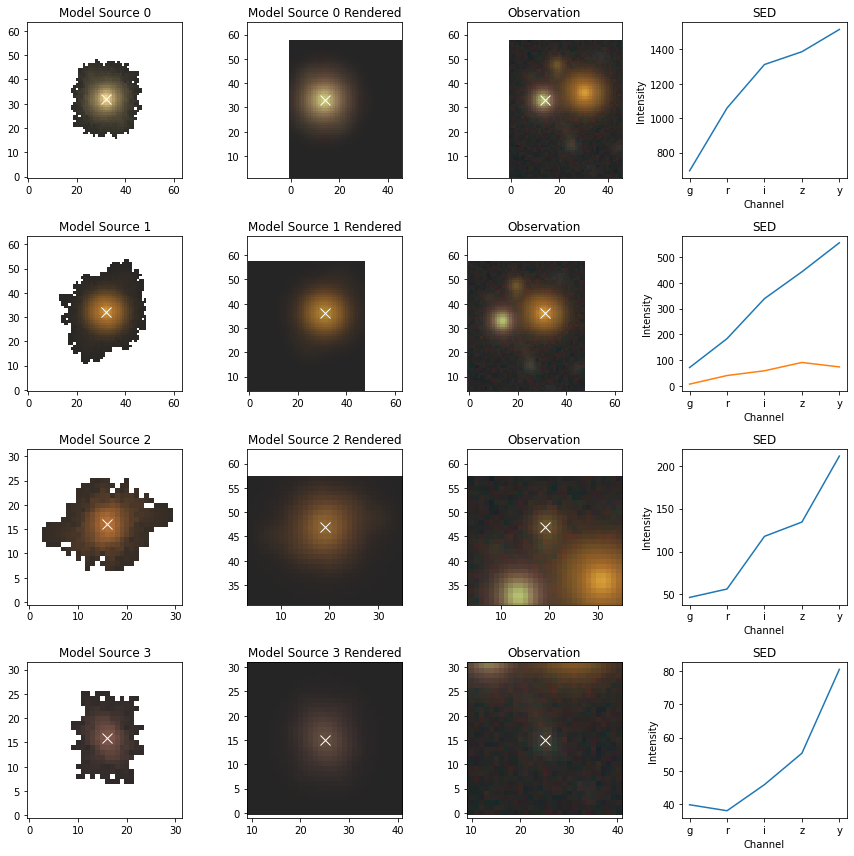

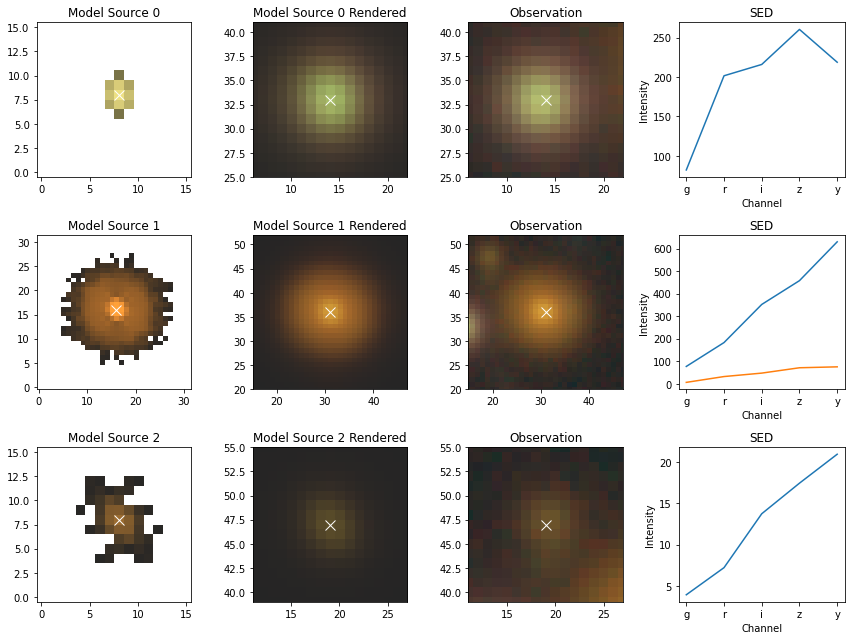

In [9]:
norm = display.AsinhMapping(minimum=np.min(images), stretch=np.max(images)*0.055, Q=10)
display.show_sources(sources[:4],
                         norm=norm,
                         observation=observation,
                         show_rendered=True,
                         show_observed=True)
plt.show()

display.show_sources(deconvolved_sources[:3],
                         norm=norm,
                         observation=observation,
                         show_rendered=True,
                         show_observed=True)
plt.show()

Notice that the deconvovled initial models use much smaller boxes while still capturing all of the features in the true observations. The better initial guess and smaller boxes will make it much faster to deblend:

CPU times: user 3.08 s, sys: 3.81 ms, total: 3.08 s
Wall time: 3.08 s
scarlet ran for 132 iterations to logL = 25966.54434486492


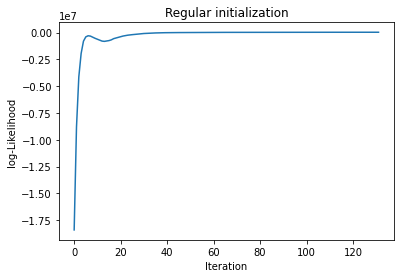

In [10]:
# Fit the non-deconvolved blend
blend = scarlet.Blend(sources, observation)
%time blend.fit(200)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend.loss), -blend.loss[-1]))
plt.plot(-np.array(blend.loss))
plt.title("Regular initialization")
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')
plt.show()

CPU times: user 980 ms, sys: 0 ns, total: 980 ms
Wall time: 980 ms
scarlet ran for 46 iterations to logL = 28749.49656974357


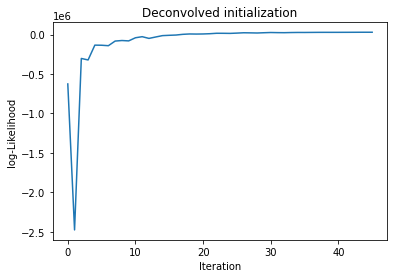

In [11]:
# Fit the deconvolved blend
deconvolved_blend = scarlet.Blend(deconvolved_sources, observation)
%time deconvolved_blend.fit(200)
print("scarlet ran for {0} iterations to logL = {1}".format(len(deconvolved_blend.loss), -deconvolved_blend.loss[-1]))
plt.plot(-np.array(deconvolved_blend.loss))
plt.title("Deconvolved initialization")
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')
plt.show()

So we see that using the deconvolved images for initialization cut our runtime in half for this particular blend (this difference might not be as pronounced in the notebook environment because the default initialization is executed first, heating up the processors before the second blend is run). Looking at the residuals we see that the final models are comparable, so when the same kernel can be used on multiple blends this method proves to be quite useful.

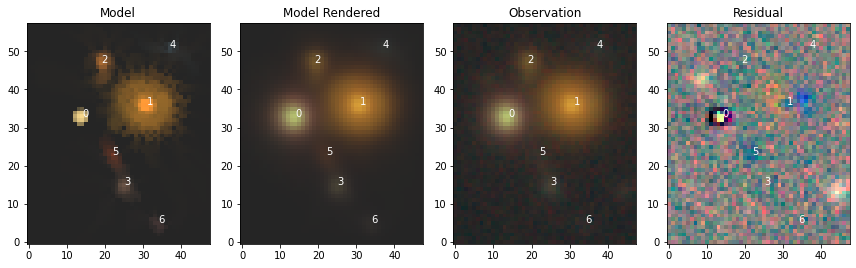

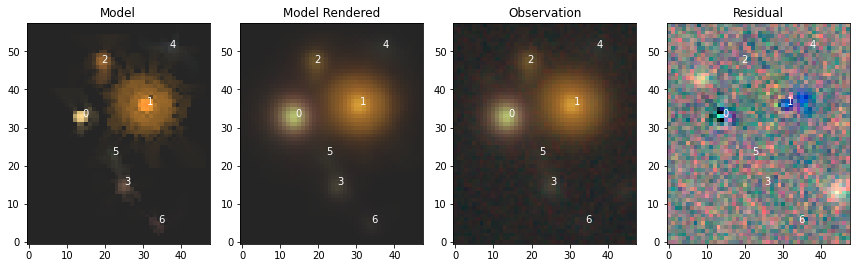

In [12]:
norm = display.AsinhMapping(minimum=np.min(images), stretch=np.max(images)*0.055, Q=10)
# Display the convolved model
scarlet.display.show_scene(blend.sources,
                           norm=norm,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
plt.show()
# Display the deconvolved model
scarlet.display.show_scene(deconvolved_blend.sources,
                           norm=norm,
                           observation=observation,
                           show_rendered=True,
                           show_observed=True,
                           show_residual=True)
plt.show()